# Physics-informed machine learning for Acoustics
Summer School - Forum Acusticum 2025

Mirco Pezzoli, Politecnico di Milano.

This code is an example of PINNs for inverse problem. In particular, to solve sound field reconstruction using the PINN in "Implicit neural representation with physics-informed neural networks for the reconstruction of the early part of room impulse responses" by Pezzoli et al. presented at Forum Acusticum 2023
Read the paper [here](https://www.researchgate.net/profile/Mirco-Pezzoli/publication/377549887_Implicit_Neural_Representation_With_Physics-Informed_Neural_Networks_For_The_Reconstruction_Of_The_Early_Part_Of_Room_Impulse_Responses/links/665995c6479366623a3382e3/Implicit-Neural-Representation-With-Physics-Informed-Neural-Networks-For-The-Reconstruction-Of-The-Early-Part-Of-Room-Impulse-Responses.pdf).

The model is based on a Physics-informed SIREN, which is a MLP with sinusoidal activations. Read the SIREN paper [here](https://arxiv.org/abs/2006.09661).

In [ ]:
# We start importing some libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile


#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Problem Description
We want to implement a PI-SIREN which is a MLP with sinusoidal activation and train it to estimate RIRs in a uniform linear array.

SIREN has the structure of MLP defined by several layer $\phi$ as

$g(\boldsymbol{x} ; \boldsymbol{\theta})=\left(\phi_L \circ \phi_{L-1} \circ \cdots \circ \phi_1\right)(\boldsymbol{x})$

where $x$ is the input of the MLP and $\theta$ are the learnable parameters of the model.


Each $i$th layer is characterized by sinusoidal activation leading to

$\phi_i\left(\boldsymbol{x}_i\right)=\sin \left(\omega_0 \boldsymbol{x}_i^T \boldsymbol{\theta}_i+\boldsymbol{b}_i\right)$

where $\omega_0$ is a hyperparameter that controls the freuquency of the sinusoidal function. For more details about the impact of $\omega_0$ read the [paper](https://arxiv.org/abs/2006.09661) by Sitzman.



In [ ]:


class Sine(nn.Module):
    def __init__(self, w0: float = 1.0,rowdy=True):
        """Sine activation function with w0 scaling support.

        Example:
            >>> w = torch.tensor([3.14, 1.57])
            >>> Sine(w0=1)(w)
            torch.Tensor([0, 1])

        :param w0: w0 in the activation step `act(x; w0) = sin(w0 * x)`.
            defaults to 1.0
        :type w0: float, optional
        """

        super(Sine, self).__init__()
        self.rowdy=rowdy
        if rowdy:
            self.w0 = nn.Parameter(torch.tensor(w0))
            self.w1 = nn.Parameter(torch.tensor(0.1))
            self.w2 = nn.Parameter(torch.tensor(0.1))
            self.w3 = nn.Parameter(torch.tensor(0.1))
            self.w4 = nn.Parameter(torch.tensor(0.1))
            self.w5 = nn.Parameter(torch.tensor(0.1))
            self.w6 = nn.Parameter(torch.tensor(0.1))
            self.a1 = nn.Parameter(torch.tensor(0.1))
            self.a2 = nn.Parameter(torch.tensor(0.1))
            self.a3 = nn.Parameter(torch.tensor(0.1))
            self.a4 = nn.Parameter(torch.tensor(0.1))
            self.a5 = nn.Parameter(torch.tensor(0.1))
            self.a6 = nn.Parameter(torch.tensor(0.1))

        else:
            self.w0 = w0



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._check_input(x)
        '''if self.rowdy:

        else:
            return '''
        return

    @staticmethod
    def _check_input(x):
        if not isinstance(x, torch.Tensor):
            raise TypeError(
                'input to forward() must be torch.xTensor')

class MLP(nn.Module):
    '''We defines a standard fully-connected network in PyTorch
    n_in: number of inputs
    n_out: numer of outputs
    n_hidden: number of neurons in hidden layers
    n_layers: number of hidden layers'''

    def __init__(self, n_in, n_out, n_hidden, n_layers, w0=30.0, rowdy=False):
        super().__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.w0 = w0
        self.rowdy = rowdy

        self.fcs = nn.Sequential(nn.Linear(n_in, n_hidden, bias=True), Sine(w0=w0/2.0,rowdy=rowdy))
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[nn.Linear(n_hidden, n_hidden, bias=True), Sine(w0=w0,rowdy=rowdy)]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_hidden, n_out)

        for m in self.fcs:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, -np.sqrt(6 / m.in_features) / self.w0,
                                             np.sqrt(6 / m.in_features) / self.w0)#-1/self.n_in, 1/self.n_in)

        for m in self.fch:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, -np.sqrt(6 / m.in_features) / self.w0,
                                             np.sqrt(6 / m.in_features) / self.w0)


    def forward(self, x):
        x = self.fcs(x) # First layer
        x = self.fch(x) # Hidden layers
        x = self.fce(x) # Last layer (typically linear)
        return x


'def gradient(y, x, grad_outputs=None):\n    """Compute dy/dx @ grad_outputs"""\n    if grad_outputs is None:\n        grad_outputs = torch.ones_like(y)\n    grad = torch.autograd.grad(y, [x], grad_outputs = grad_outputs, create_graph=True)[0]\n    return grad\n\ndef jacobian(y, x):\n     #jacobian of y wrt x \n    meta_batch_size, num_observations = y.shape[:2]\n    jac = torch.zeros(meta_batch_size, num_observations, y.shape[-1], x.shape[-1]).to(y.device) # (meta_batch_size*num_points, 2, 2)\n    for i in range(y.shape[-1]):\n        # calculate dydx over batches for each feature value of y\n        y_flat = y[...,i].view(-1, 1)\n        # y_flat = y[...,i]\n        jac[:, :, i, :] = gradient(y_flat, x, torch.ones_like(y_flat))[0]\n    return jac\n    '

## Task: Inverse Problem i.e., train PINN to estimate RIRs from sparse measuements

### Goal
The goal of the PINN is to estimate the signals of missing microphones within a uniform linear array. This can be described in general as an interpolation problem.

$\arg\min || \mathbf{y}(r,t) - f(\mathbf{x};\mathbf{\theta})||^2 + \mathcal{R}(\theta)$

In this case the PDE loss acts as a regularizer for the estimation of the MLP. In particular we implement the homogenous wave equation

$\nabla^2U(r,t)+\frac{1}{c^2}\frac{\partial^2}{\partial t^2}U(r,t) = 0$

In practice only spatial coordinate will be considered and the temporal coordinate.

The ULA is composed of 100 microphones and a random number of sensors (approx. 30) will be removed, simulating missing sensors.

### How to proceed
1. Train the PINN without removing any channel from the array and using only the data loss. This data fit will show if architecture works.
2. Impose the random mask to remove channels from the ULA and train the network.

3. Add the PDE loss to the training, what can you observe? You probably have to play with weighting factor $\lambda$






--2025-06-21 09:16:51--  https://github.com/m-pexx/fa25-summer-school/raw/refs/heads/main/data/simulated_rir2.wav
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m-pexx/fa25-summer-school/refs/heads/main/data/simulated_rir2.wav [following]
--2025-06-21 09:16:51--  https://raw.githubusercontent.com/m-pexx/fa25-summer-school/refs/heads/main/data/simulated_rir2.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102444 (100K) [audio/wav]
Saving to: ‘simulated_rir2.wav.78’

simulated_rir2.wav. 100%[===================>] 100.04K  --.-KB/s    in 0.02s   

2025-06-21 09:16:51 (4.28 MB/s) - ‘simulated_r

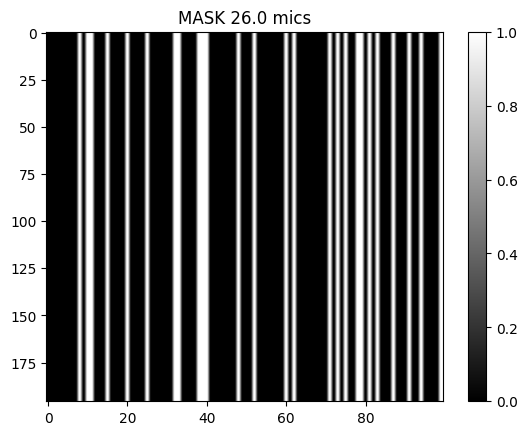

Loss: 0.045793 MSE: 0.045792 PDE 0.000000


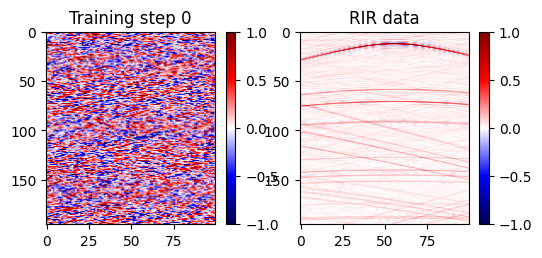

Loss: 0.000265 MSE: 0.000265 PDE 0.000000


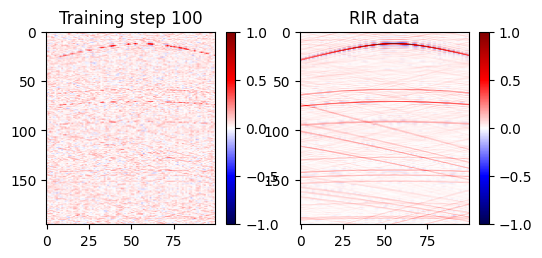

Loss: 0.000017 MSE: 0.000017 PDE 0.000000


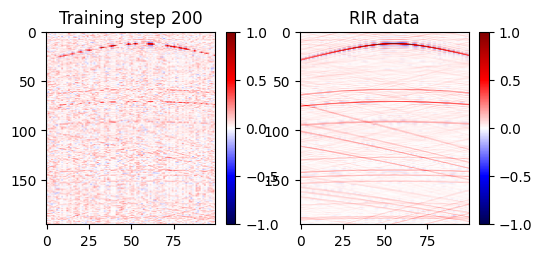

Loss: 0.000058 MSE: 0.000058 PDE 0.000000


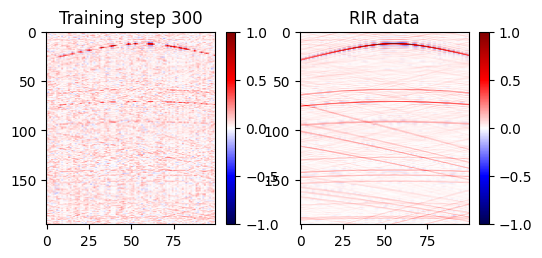

Loss: 0.000042 MSE: 0.000041 PDE 0.000000


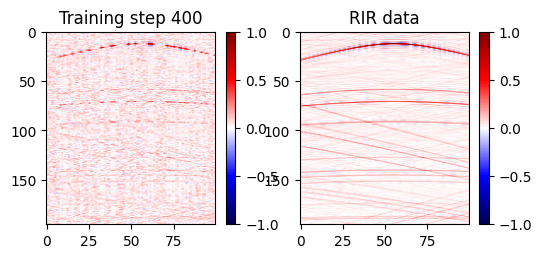

Loss: 0.000033 MSE: 0.000033 PDE 0.000000


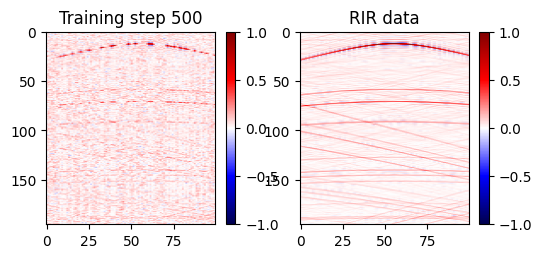

Loss: 0.000057 MSE: 0.000057 PDE 0.000000


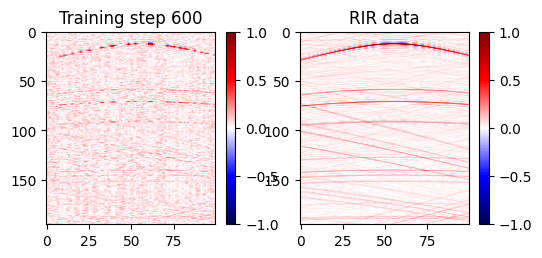

Loss: 0.001180 MSE: 0.001180 PDE 0.000000


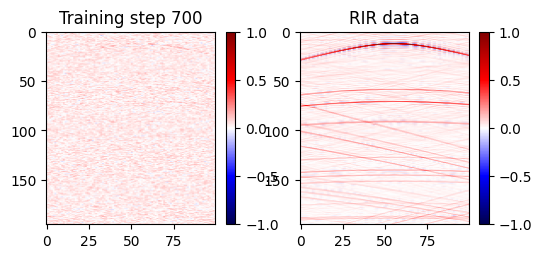

Loss: 0.000032 MSE: 0.000032 PDE 0.000000


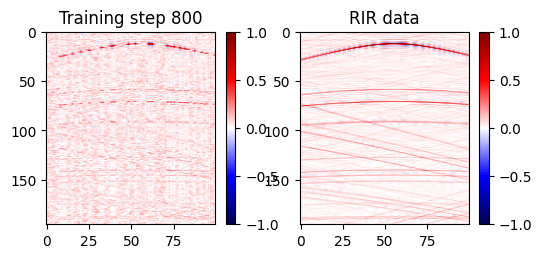

Loss: 0.000537 MSE: 0.000537 PDE 0.000000


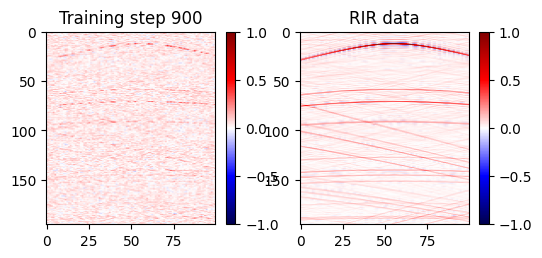

Loss: 0.000751 MSE: 0.000751 PDE 0.000000


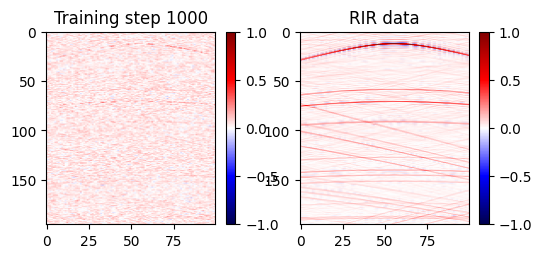

Loss: 0.000777 MSE: 0.000777 PDE 0.000000


KeyboardInterrupt: 

In [ ]:
torch.manual_seed(1111)
c = 343.0 # Speed of sound
signal_length = 196 # Trim the time dimension to save computation time
# Load the RIR data
!wget https://github.com/m-pexx/fa25-summer-school/raw/refs/heads/main/data/simulated_rir2.wav
rate, data = wavfile.read("simulated_rir2.wav")

# Normalize the RIRs to peak
data =
init_signal = 0
data = data[init_signal:signal_length+init_signal,:]
image_resolution = data.shape
dim_product = image_resolution[0]*image_resolution[1]

# We train the model on GPU, thus we need to load the data on the device memory
data_torch = torch.tensor(data, dtype=torch.float32).to(device)

# We compute the mask for missing microhones
mask_np = np.ones(image_resolution)
idx = np.diag(np.random.choice([0, 1], size=image_resolution[1], p=[.3, .7]))
mask_np = mask_np @ idx
mask = torch.tensor(mask_np)
mask = mask.float().cuda().contiguous()

'''!wget https://github.com/m-pexx/fa25-summer-school/raw/refs/heads/main/data/mask_33.wav
rate, mask_np = wavfile.read("mask_33.wav")
mask_np = mask_np[init_signal:signal_length, :] / np.max(mask_np)
mask = torch.tensor(mask_np)
mask = mask.float().cuda().contiguous()'''


available_channels = np.sum(mask_np, 1)[0]
# Show the mask image

plt.show()


# Let's compute the domain of sound field data.
# We consider normalized cordinates between -1 and 1
# To train the PINN we need a dense domani, thus the cartesian product of the
# two axis is required.
# TODO: write code here (hint: use meshgrid)

x_values =
y_values =
X, Y =
X_flat = X.flatten()
Y_flat = Y.flatten()
coords_matrix = np.vstack((X_flat, Y_flat)).T

# Send data to the GPU
t_physics = torch.tensor(coords_matrix, dtype=torch.float32).requires_grad_(True).to(device)


# Define the PI-SIREN
# TODO: write code here
pi_siren =

# Optional print the model
#print(pi_siren)

optimiser = torch.optim.Adam(pi_siren.parameters(),lr=1e-3)

# TRAINING LOOP!!
# Loss balancing parameter
# TODO: write code here
lambda1 =
lambda2 =

for i in range(5000):
    optimiser.zero_grad()

    # Compute RIR estimate
    # TODO: write code here
    U = pi_siren(t_physics)

    # Compute the data loss and multiply using the mask to remove unknown locations
    # |y-U|^2*M
    # TODO: write code here
    loss1 = ((torch.abs(torch.squeeze(U)-data_torch.view(-1))*mask.view(-1))**2).mean()

    # Get the 2nd order derivatives with respect to space and time
    # TODO: write code here

    dUdT = torch.autograd.grad(U, t_physics, torch.ones_like(U), create_graph=True)[0]
    d2UdT2 = torch.autograd.grad(dUdT, t_physics, torch.ones_like(dUdT), create_graph=True)[0]
    dudt2 = d2UdT2[:,0]
    lap = d2UdT2[:,1]


    # TO DO
    pde_res =
    loss2 = (torch.abs(pde_res)**2).mean()


    loss =
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 100 == 0:
      print("Loss: %0.6f MSE: %0.6f PDE %0.6f" %(loss.item(), lambda2*loss1.item(), lambda1*loss2.item()))
#      print("Loss: %0.6f MSE: %0.6f" %(loss.item(), lambda2*loss1.item()))#, lambda1*loss2.item()))

      U = pi_siren(t_physics)
      plt.figure(figsize=(6,2.5))
      plt.subplot(1,2,1)
      plt.imshow(U.detach().cpu().numpy().reshape(image_resolution),vmax=1, vmin=-1, aspect="auto", cmap="seismic")
      plt.colorbar()
      plt.title(f"Training step {i}")
      plt.subplot(1,2,2)
      plt.imshow(data_torch.detach().cpu().numpy(), vmax=1, vmin=-1, aspect="auto", cmap="seismic")
      plt.colorbar()
      plt.title("RIR data")
      plt.show()



## Experiments
Try different values for $\omega_0$ and combination of layers or $\lambda$.

Kee track on how the estimation changes accordingly to the different hyperparameters.

## Rowdy activation

Try to implement the Rowdy activation within the SIREN class. As a guideline use the following formula

$\sin(\omega_0 x) + \sum_{n=1}^6 n\sin(n x)$ with $\omega_0 = 1$

Comment the training performance...